<a href="https://colab.research.google.com/github/sauddy/DPNNet-Bayesian/blob/main/DPNNet_Bayesian_FP_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DPNNet-Bayesian 


Planet-induced substructures, like annular gaps, observed in dust emission from protoplanetary disks, provide a unique probe for characterizing unseen young planets. While deep-learning-based models have an edge in characterizing a planet's properties over traditional methods, such as customized simulations and empirical relations, they lacks the ability to quantify the uncertainties associated with their predictions. In this paper, we introduce a Bayesian deep-learning network, "DPNNet-Bayesian," which can predict planet mass from disk gaps and also provides the uncertainties associated with the prediction. A unique feature of our approach is that it is able to distinguish between the uncertainty associated with the deep-learning architecture and the uncertainty inherent in the input data due to measurement noise. The model is trained on a data set generated from disk–planet simulations using the fargo3d hydrodynamics code, with a newly implemented fixed grain size module and improved initial conditions. The Bayesian framework enables the estimation of a gauge/confidence interval over the validity of the prediction, when applied to unknown observations. As a proof of concept, we apply DPNNet-Bayesian to the dust gaps observed in HL Tau. The network predicts masses of 86.0 ± 5.5 M⊕, 43.8 ± 3.3 M⊕, and 92.2 ± 5.1 M⊕, respectively, which are comparable to those from other studies based on specialized simulations.

Link to the published paper

[Using Bayesian Deep Learning to Infer Planet Mass from Gaps in Protoplanetary Disks](https://iopscience.iop.org/article/10.3847/1538-4357/ac7a3c)


In [ ]:


'''
    This notebook is used to post-process the data obtained from the 
    FARGO3D simulations for the Disk-Planet interaction and to 
    train the DPNNet (Disk Planet Neural Network - Bayesian).

    

    Summary   : We introduce the use of Bayesian Formalism in Neural Network.
                We adapt a Bayesian deep-learning network, "DPNNet-Bayesian," 
                which can predict planet mass from disk gaps and also provides the 
                uncertainties associated with the prediction. A unique feature of our
                approach is that it is able to distinguish between the uncertainty 
                associated with the deep-learning architecture and the uncertainty 
                inherent in the input data due to measurement noise. 

                To train the model to predict planet mass from  
                measured dust gap/gaps and other disk parameters from Simulations 
                with Fixed particles size

    Code : The code is adopted from the Google Tensor Flow platform
    
    Modification 1 : 4 August : We update this code to use a more modular version
                    The hyperparamters used are now optimized used keras-tuner.
                    But we shall implement the Bayesian version of DPNNet

    Modification 2 : 25 August 2021 Flaring index is now cosidered
                 3 : 1 September included early stopping with decaying damping rate

                 4. November 15 2021: Setting the final runs for the paper p2
                 5. August 31 to add some comments before uploading to Guthub
                     

    ArXiv Link to 1st paper : https://arxiv.org/abs/2007.13779
'''

# Author :  Sayantan
# Created : June 2 2021





## Importing the required modules
## Modules for data handling
import glob
import pandas as pd
import numpy as np
import scipy as sp

## Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

## Modules for tensorflow model development
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import r2_score ## form calcualting the r2 score

print(tf.__version__)

import h5py


2.7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Path_gdrive= '/content/drive/MyDrive/DPNNet-FP-Bayesian/FP_bayesian_MLP_version/'
import os
os.chdir(Path_gdrive)

## Import the dpnnet_class
import dpnnet_class as dp
print("Creating the folders for saving the processed data and save the figures")
## Folders to save the filtered data
!mkdir -p data_folder
!mkdir -p figures ## to save the figures

We have imported the dpnnet_class
Creating the folders for saving the processed data and save the figures


## Data Preparation and Filtering

In [ ]:
# dataset_path = '/content/drive/MyDrive/DPNNet_FP/Fixed_particle_data/'
# dataset_path ='/content/drive/MyDrive/DPNNet_FP/fixed_particle_data_21June/'
# dataset_path ='/content/drive/MyDrive/DPNNet-FP-Bayesian/analysis_output_dong3000/'
dataset_path ='/content/drive/MyDrive/DPNNet-FP-Bayesian/analysis_output_3000_FI/'


Model = dp.dpnnet(data_path=dataset_path)
dataset = Model.data_filtering()

dataset        # to take a look at the dataset e dataset 

,Planet_Mass,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2,Flaring_index
0,54.000000,0.0169,0.00344,0.0219,0.0711,0.1430,0.071,0.0,0.0544
1,35.000000,0.0387,0.00368,0.0617,0.0470,0.4560,0.767,0.0,0.0471
2,109.000000,0.0641,0.00103,0.0576,0.0936,0.3620,1.032,0.0,0.2000
4,110.000000,0.0923,0.00580,0.0869,0.0917,0.0229,0.098,0.0,0.0699
5,106.666667,0.0253,0.00484,0.0298,0.0670,0.6600,0.838,0.0,0.2220
...,...,...,...,...,...,...,...,...,...
1108,110.333333,0.0860,0.00495,0.0073,0.0735,0.9320,0.753,0.0,0.0470
1109,23.333333,0.0732,0.00452,0.0423,0.0312,1.2200,0.713,0.0,0.1740
1110,70.333333,0.0630,0.00318,0.0379,0.0802,0.0936,0.795,0.0,0.1600
1111,104.000000,0.0537,0.00610,0.0723,0.0388,0.7710,0.823,0.0,0.0349


In [ ]:
# sns.pairplot(dataset[["Planet_Mass","Epsilon","Alpha", "Stokes","Aspect_Ratio" ,"Dust_gap_1",'SigmaSlope','Flaring_index']], diag_kind="kde")
# plt.savefig('figures/relations.pdf')

## Splitting the data in Training and Testing set

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = Model.data_processing()

## save the processed dataset
X_test_scaled.to_csv(Path_gdrive+'data_folder/X_test_scaled.csv')
X_train_scaled.to_csv(Path_gdrive+'data_folder/X_train_scaled.csv')
y_test.to_csv(Path_gdrive+'data_folder/y_test.csv')
y_train.to_csv(Path_gdrive+'data_folder/y_train.csv')

The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...


# Defining DPNNet architecture
## Model build and Compile

In [ ]:
## Training the model
## Unit 1 and Unit 2 can be specified: Or else it will use the default 
## values from the paper 1 256 and 128

# model = Model.build_model(unit1=160,unit2=64, Bayesian = True)
# model = Model.build_model(unit1=224,unit2=64, Bayesian = True)
model = Model.build_model(unit1=None,unit2=None, Bayesian = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=400) ## early stopping is used to minimize overfitting
history = model.fit(X_train_scaled,y_train,epochs=10000,validation_split = 0.2, verbose=1,callbacks=[early_stop])

# history = model.fit(X_train_scaled,y_train,epochs=10000,validation_split = 0.2, verbose=1)

We are now using the DPNNet Architecture
The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...
Implementing Bayesian in the last layer
Epoch 1/10000
22/22 [==============================] - 4s 60ms/step - loss: 6260.1548 - mean_absolute_error: 73.2269 - mean_squared_error: 6258.9717 - val_loss: 5514.9468 - val_mean_absolute_error: 68.8394 - val_mean_squared_error: 5510.7749
Epoch 2/10000
22/22 [==============================] - 0s 13ms/step - loss: 5425.8472 - mean_absolute_error: 67.1993 - mean_squared_error: 5417.1987 - val_loss: 4942.8809 - val_mean_absolute_error: 64.1699 - val_mean_squared_error: 4931.3511
Epoch 3/10000
22/22 [==============================] - 0s 15ms/step - loss: 4771.7886 - mean_absolute_error: 62.1150 - mean_squared_error: 4757.1665 - val_loss: 3942.5588 - val_mean_absolute_error: 56.0261 - val_mean_squared_error: 3918.1670
Epoch 4/10000
22/22 [========

In [ ]:
model.summary()
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
## Saving the history
hist.to_csv(Path_gdrive+'data_folder/'+'Bayesian_history.csv')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_variational (DenseVar  (None, 128)              98688     
 iational)                                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 101,121
Trainable params: 101,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ## Loading the history of the CNN and the Hybrid model
Bayesian_history = pd.read_csv(Path_gdrive+'data_folder/'+'Bayesian_history.csv',index_col=0) ## trained dataset
# Bayesian_history
# hist.tail()

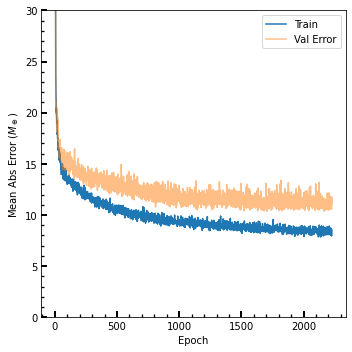

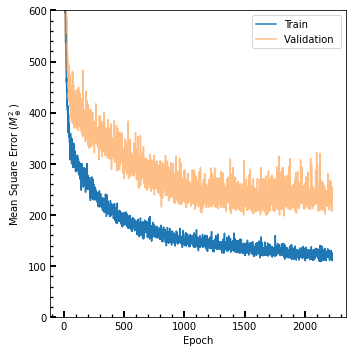

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(5,5))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ($M_\oplus$)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train ')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],alpha=0.5,
           label = 'Val Error')
  plt.ylim([0,30])
  plt.minorticks_on()
  plt.tick_params(labelsize=10)
  plt.tick_params(axis='both', which='major',length=6, width=2)
  plt.tick_params(axis='both', which='minor',length=3, width=1.3)  
  plt.tight_layout()
  plt.savefig('figures/MAEvalidation_loss.pdf',format='pdf',dpi=300)
  plt.legend()

  plt.figure(figsize=(5,5))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error ($M_\oplus^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],alpha=0.5,
           label = 'Validation ')
  plt.ylim([0,600])
#   plt.xlim([0,700])
#   plt.yscale("log")
  plt.legend()
  plt.minorticks_on()
  plt.tick_params(labelsize=10)
  plt.tick_params(axis='both', which='major',length=6, width=2)
  plt.tick_params(axis='both', which='minor',length=3, width=1.3)  
  plt.tight_layout()
  plt.savefig('figures/MSEvalidation_loss.pdf',format='pdf',dpi=300)
  plt.show()

  
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))

Testing set Mean Square Error: 173.86 
Testing set Root Mean Square Error: 13.19 M_Earth
Testing set Mean Abs Error:  9.48 M_Earth
Testing set Loss : 192.73 M_Earth


## Saving the network for future use

In [ ]:
# uncomment the following lines if you want to update your model
!mkdir -p saved_model


model_name = "DPNNet_Bayesian_FP" ## saving the final value with 256 and 128, lr=0.001 Random=3 and patience 400,15 december 2021
# model_name = "DPNNet_Bayesian_FP_lr" lr =0.0001
## Models Below are test cases

# model_name = "DPNNet_Bayesian_FP_22464"  ## using the keras optimized values 224 and 64 patience 300 learning rate 0.0001 (ran in sharcnet)
## Currently the models are saved based in thg choice of patience. The last digit corresponds to the first digit on the patience parameter
## 33 patience 300 44 patience 400
# model_name = "DPNNet_Bayesian_FP_p1"  #this is the saved model with keras same weights as DPNNet
# model_name = "DPNNet_Bayesian_FP_p2"    #this is the saved model where we are finding he best r2-score the best model r2 = .0.87
# model_name = "DPNNet_Bayesian_FP_p3"    #this is the saved model where we are finding he best r2-score
#model_name = "DPNNet_Bayesian_FP_p44" ## patience 800  ## patience 600  #this is the saved model where we are finding he best r2-score




file = h5py.File('saved_model/{}.h5'.format(model_name), 'w')
weight = model.get_weights()
for i in range(len(weight)):
   file.create_dataset('weight' + str(i), data=weight[i])
file.close()


## Loading the saved Model

In [ ]:
# new_model = tf.keras.models.load_model('saved_model/my_model')
# # Check its architecture

file = h5py.File('saved_model/{}.h5'.format(model_name), 'r')
weight = []
for i in range(len(file.keys())):
   weight.append(file['weight' + str(i)][:])

new_model = Model.build_model(unit1=None,unit2=None, Bayesian = True)
# new_model = Model.build_model(unit1=160,unit2=64, Bayesian = True)
# new_model = Model.build_model(unit1=224,unit2=64, Bayesian = True)

new_model.set_weights(weight)
# new_model = model
new_model.summary()


We are now using the DPNNet Architecture
The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...
Implementing Bayesian in the last layer
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 256)               2304      
                                                                 
 dense_variational_1 (DenseV  (None, 128)              98688     
 ariational)                                                     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total p

In [ ]:
loss, mae, mse = new_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))

Testing set Mean Square Error: 165.43 
Testing set Root Mean Square Error: 12.86 M_Earth
Testing set Mean Abs Error:  9.15 M_Earth
Testing set Loss : 183.65 M_Earth


## Making the plot with the epistemic uncertainty

In [ ]:
## Calculating the Epistemic Uncertainty

# Use list comprehension tp predict over the test dataset for N number of times each.
interval =200 ## This corresponds to the number of trials for the epistemic uncerstainty
yhat = [model.predict(X_test_scaled).flatten() for _ in range(interval)]
## Taking a look at the predicted values (y_hat) for each of the draws along with the actual y
df  =pd.DataFrame(yhat).T
df['y'] = y_test.values
df.head()
import itertools
sample_preds = list(itertools.chain.from_iterable([[(j,x[-1]) for j in x if j != x[-1]]for x in df .values]))
## Sample for predicted and the actual value for test case 
# sample_preds[:15] ## printing 15 samples

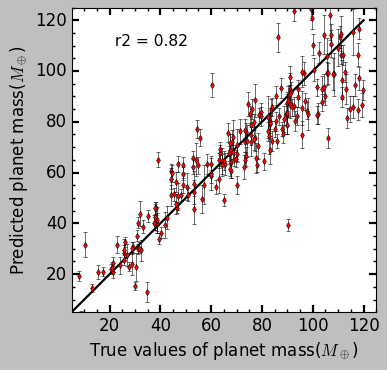

In [ ]:
plt.style.use('classic')
df.shape[0]
N=0
# interval=200
pred_value_mean = []
pred_value_std = []
actual_value = []
for i in range (0,df.shape[0]):
  predicted_values = [x[0] for x in sample_preds[N:N+interval]]
  actual_values = [x[1] for x in sample_preds[N:N+interval]]
  N = interval + N
  pred_value_mean.append(np.mean(predicted_values))
  pred_value_std.append(np.std(predicted_values))
  actual_value.append(np.mean(actual_values))

r_score = r2_score(actual_value,pred_value_mean)

plt.figure(figsize = (5,5))
# plt.scatter([x[1] for x in sample_preds],[x[0] for x in sample_preds],alpha = 0.01,c = 'r')
plt.scatter(actual_value,pred_value_mean,alpha = 0.01,c = 'r')
plt.errorbar(actual_value,pred_value_mean, yerr=pred_value_std, lw=0,elinewidth=0.5,ecolor='k', fmt='d',markersize=4,color='red',capsize=2,label= 'DPNNet')
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2,c='k')
plt.text(20,110,r" r2 = {:.2f}".format(r_score), fontsize =14)
plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
# plt.savefig('predicted_correlation.eps',format='eps',dpi=300)


## A test case 

In [ ]:
## One test case for the demonstration in the paper
test_index = 120
# print(test_dataset.iloc[[test_index]])
print("Actual Planet Mass is ", y_test.iloc[[test_index]])
# normed_test_data.iloc[[4]]
print("Predicted Planet Mass is " , model.predict(X_test_scaled.iloc[[test_index]]))

Actual Planet Mass is  1078    38.333333
Name: Planet_Mass, dtype: float64
Predicted Planet Mass is  [[48.393715]]


## Using DPNNet to predict the planet mass from observed gap widths in HL-Tau

In [ ]:
##  Lets predict the Mass of Hl Tau disk

## need to guess from the observation
Epsilon = 0.01
SigmaSlope = 1 ## this is the mean value from the parameter space
Stokes = 0.005
Alpha = 0.001
Flaring_index = 0.1 ## Need to update this

## Will use the values from the Kanagawa paper
Aspect_Ratio= [0.05,0.07,0.1]
Dust_gap = [0.81,0.23,0.29]

Dust_gap_2 = 0.000 ## using a default value of zero
N =1000
yhat_hL_tau = np.empty((len(Aspect_Ratio), N))
for index in range(len(Aspect_Ratio)):
    df_HL = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio[index],SigmaSlope,Dust_gap[index],Dust_gap_2,Flaring_index]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
    print("The Predicted planet mass in ring#",index,"is",model.predict(Model.normalization(df_HL)))

    ## Use list comprehension tp predict over the test dataset for 100 times.
    # yhat = [model.predict(norm(df_HL)).flatten() for _ in range(N)]  
    yhat_hL_tau[index,:] = [model.predict(Model.normalization(df_HL)).flatten() for _ in range(N)]  


The Predicted planet mass in ring# 0 is [[91.8542]]
The Predicted planet mass in ring# 1 is [[52.873333]]
The Predicted planet mass in ring# 2 is [[88.39608]]


90.0 4.0


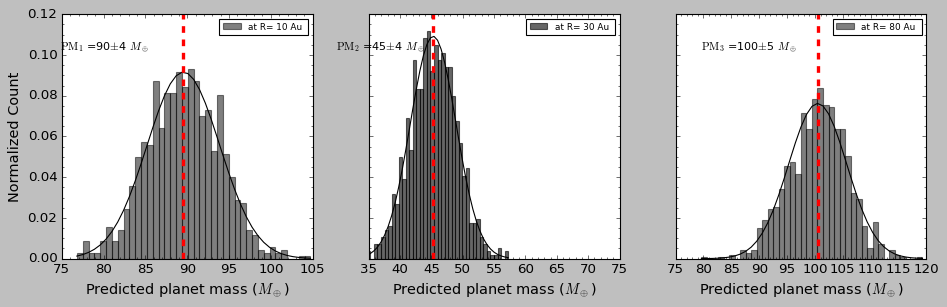

In [ ]:
df_HL_Tau  = pd.DataFrame(yhat_hL_tau).T
bi= 40

f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey = True ,sharex=False,figsize=(12,4))
ax1.minorticks_on() 
# plt.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
count, bins, _ = ax1.hist(df_HL_Tau[0], bins=bi, alpha=0.5,color="k",edgecolor='k',density=True,label= "at R= 10 Au ")
mu, sigma = sp.stats.norm.fit(df_HL_Tau[0])
print(round(mu,0),round(sigma,0))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# xmin, xmax = 110, 140
# x_ = np.linspace(xmin, xmax, 41)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL_Tau[0].min()-2
# print(x_start)
y_pos = count.max()*1.1
ax1.text(x_start,y_pos,r"$\rm PM_1$ ={:.0f}$\pm${:.0f} $M_\oplus$".format(round(mu,0),round(sigma,0)),fontsize=10)

_, bins, _ = ax2.hist(df_HL_Tau[1], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 30 Au ")
mu, sigma = sp.stats.norm.fit(df_HL_Tau[1])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
ax2.set_xlim(35,75)
x_start = df_HL_Tau[1].min()-5
ax2.minorticks_on() 
ax2.text(x_start,y_pos,r"$\rm PM_2$ ={:.0f}$\pm${:.0f} $M_\oplus$".format(round(mu,0),round(sigma,0)),fontsize=10)

_, bins, _ = ax3.hist(df_HL_Tau[2], bins=bi,alpha=0.5,color="k",edgecolor='k',density=True,label= "at R= 80 Au ")
mu, sigma = sp.stats.norm.fit(df_HL_Tau[2])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax3.plot(bins, best_fit_line,color="k")
ax3.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL_Tau[2].min()
ax3.text(x_start,y_pos,r"$\rm PM_3$ ={:.0f}$\pm${:.0f} $M_\oplus$".format(round(mu,0),round(sigma,0)),fontsize=10)
ax3.minorticks_on() 

ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
# ax1.set_ylabel(r'Count',fontsize=13)


# # plt.axis('equal')
# plt.axis('square')
plt.tight_layout()

## Using DPNNet to predict the planet mass from observed gap widths in AS 209

In [ ]:
#Predict the planet mass in AS 209 disk
## Note that the central star in 0.83 M_{\sun}
# AS209_1 Paramters used from Zhang et al 2018

df_AS209=np.empty((2, N))
M_star = 0.83 ## from Zhang et al 2018
Dust_gap_2 = 0.00 ## using a default value of zero

Dust_gap = 0.42
Epsilon = 0.012 # 1.23/100
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.04
Flaring_index = 0.1 ## Need to update this

df_AS209_1 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
df_AS209[0,:] = [model.predict(Model.normalization(df_AS209_1)).flatten() for _ in range(N)] 
print("The Predicted planet mass in ring AS209_1#",model.predict(Model.normalization(df_AS209_1))*M_star)

# AS209_2
Dust_gap = 0.31
Epsilon = 0.02   #####0.17/10
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.08
Flaring_index = 0.1 ## Need to update this

df_AS209_2 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
df_AS209[1,:] = [model.predict(Model.normalization(df_AS209_2)).flatten() for _ in range(N)] 
print("The Predicted planet mass in ring AS209_2#",model.predict(Model.normalization(df_AS209_2))*M_star)

The Predicted planet mass in ring AS209_1# [[27.23734]]
The Predicted planet mass in ring AS209_2# [[31.745691]]


28.0 3.0


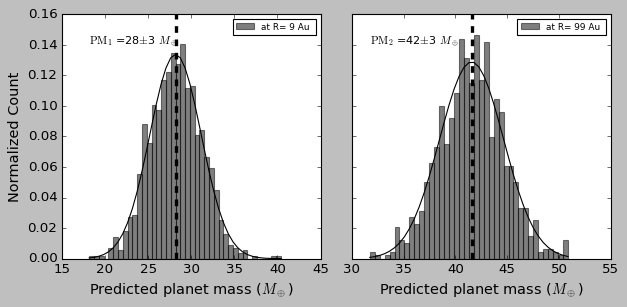

In [ ]:
# print(yhat)
df  = pd.DataFrame(df_AS209).T
# df.head()
# bi= 40
# ax[idx].hist(df.iloc[:,idx], bins=12, alpha=0.5)
# df[1].diff().hist(color="k", alpha=0.5, bins=50)
# df.iloc[0].diff().hist(color="k", alpha=0.5, bins=50)
# df.iloc[0].hist(bins=bins,density=True, facecolor='r', alpha=0.6)
# plt.figure()

f, [ax1,ax2] = plt.subplots(1, 2, sharey = True ,sharex=False,figsize=(8,4))
count, bins, _ = ax1.hist(df[0], bins=bi, alpha=0.5,color="k",edgecolor='k',density=True,label= "at R= 9 Au ")
mu, sigma = sp.stats.norm.fit(df[0])
print(round(mu,0),round(sigma,0))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="k",linestyle = "--",linewidth =3)
x_start = df[0].min()
# print(x_start)
y_pos = count.max()*1.0
ax1.text(x_start,y_pos,r"$\rm PM_1$ ={:.0f}$\pm${:.0f} $M_\oplus$".format(round(mu,0),round(sigma,0)),fontsize=10)

_, bins, _ = ax2.hist(df[1], bins=bi, alpha=0.5,color="k",edgecolor='k',density=True, label= "at R= 99 Au ")
mu, sigma = sp.stats.norm.fit(df[1])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="k",linestyle = "--",linewidth =3)
x_start = df[1].min()

ax2.text(x_start,y_pos,r"$\rm PM_2$ ={:.0f}$\pm${:.0f} $M_\oplus$".format(round(mu,0),round(sigma,0)),fontsize=10)

ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
# ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
# ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
# plt.minorticks_on() 
# plt.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
# # plt.axis('equal')
# # plt.axis('square')
# plt.tight_layout()
# plt.axis('square')
# plt.savefig( "figure_Paper/AS209_planet_mass.png",format='png',dpi=500,bbox_inches = 'tight')
plt.tight_layout()